In [1]:
from PIL import Image
import numpy as np
import cv2 as cv
import pandas as pd
import os
from pathlib import Path
import boto3

# EDA Part 2.3
### Modify a single chest x-ray to give it a foreign body. Three different types of foreign bodies added: 1. Coin in trachea 2. Magnets in stomach 3. Bullet in chest.

In [2]:
train_df_key = 'unzipped/train.csv'

In [3]:
p = Path(train_df_key)

In [4]:
df_train = pd.read_csv(p)
df_train.shape

(223414, 19)

223,414 patients with chest x-rays. A huge dataset.

# Example image from 2.1
Here we take a closer look at the example image taken from 2.1. We add a coin in the trachea, before the bifurcation into left and right main bronchus.

In [5]:
sample_path = 'unzipped/train/patient00005/study1/view1_frontal.jpg'

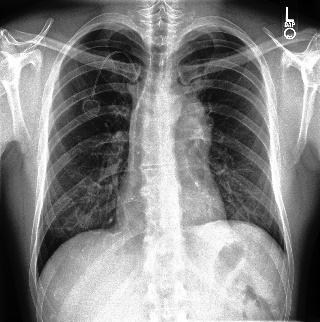

In [6]:
# fronm prior notebook.
# img = Image.open|(Path('../2.1_Download_View_Single_Image/') / sample_path)
img_raw = Image.open(Path(sample_path))
img = img_raw.copy()
img.show()

In [7]:
sample_path_mod = Path(*Path('unzipped/train/patient00005/study1/view1_frontal.jpg').parts[1:])

Below we can see the attributes of this particular chest x-ray.

In [8]:
print(df_train[df_train['Path'].str.contains(str(sample_path_mod))])

                                                Path   Sex  Age  \
7  CheXpert-v1.0-small/train/patient00005/study1/...  Male   33   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
7         Frontal    PA         1.0                         NaN           0.0   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
7           NaN          NaN    NaN            0.0        NaN          NaN   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
7           NaN               0.0            NaN       NaN              1.0  


In [9]:
width, height = img.size

## 1. Circle 'coin' feature modification

Here I have fixed the random generator of x and y values so that it no longer takes from the uniform [0,1] distribution. It now samples from the uniform [-1,1] distribution. I did this because the previous version was inappropriately always placing the coin to the patient's left (our right).

In [10]:
# Add coin

circle_radius = 10

x = int((width* (0.5+ np.random.uniform(low = -1, high = 1)*0.01)))
y = int((height*(0.15+ np.random.uniform(low = -1, high = 1)*0.1)))

circle_centre = (x,y)


img = cv.circle(np.array(img), (x,y), circle_radius, 255, -1)

save_path = Path(f'image_result/') / sample_path_mod.with_suffix('') / Path(f'mod_circle_x_{x}_y_{y}_radius_{circle_radius}.jpg')
save_path.parent.mkdir(parents=True, exist_ok=True)

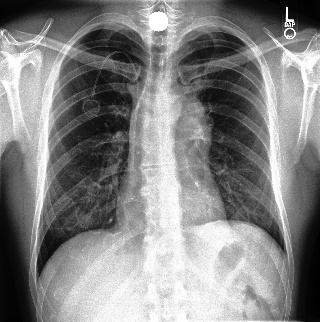

In [11]:
img = Image.fromarray(img)
img.show()

Compared the above to the real coin in trachea image below.

![real coin in trachea](../../images/coin_trachea.jpg)

In [12]:
img.save(save_path)

## 2. Double circle 'Two magnets stuck together' feature addition

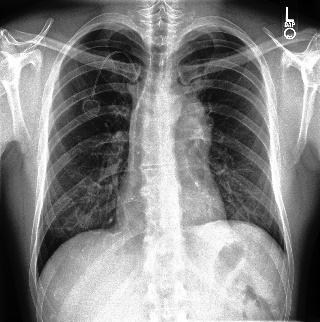

In [13]:
# Add two magnet stuck together
img = img_raw.copy()
img.show()

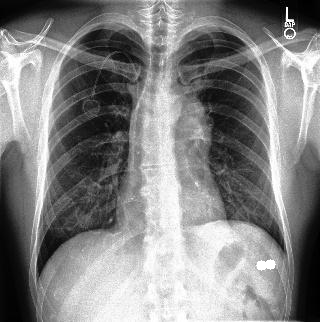

In [14]:
circle_radius = 5

x1 = int((width* (0.7+ np.random.uniform(low = -1, high = 1)*0.14)))
y1 = int((height*(0.8+ np.random.uniform(low = -1, high = 1)*0.05)))

theta = np.random.uniform(low = 0, high = 2*np.pi)

x2 = int(x1 + 2*circle_radius*np.cos(theta))
y2 = int(y1 + 2*circle_radius*np.sin(theta))

circle_centre1 = (x1,y1)
circle_centre2 = (x2,y2)

img = cv.circle(np.array(img), circle_centre1, circle_radius, 255, -1)
img = cv.circle(np.array(img), circle_centre2, circle_radius, 255, -1)

img = Image.fromarray(img)
img.show()

save_path = Path(f'image_result/') / sample_path_mod.with_suffix('') / Path(f'mod_magnet_x_{x1}_y_{y1}_rotation_{theta*180/np.pi:.0f}.jpg')

save_path.parent.mkdir(parents=True, exist_ok=True)
img.save(save_path)

The results are subtle, but you can see two circles have been added to the patient's lower left (our lower right) where the stomach lies. The circles are touching, because magnets attract each other in the gut. This is why they are so dangerous - they can 'pinch' the bowel and cause an obstruction. 

You can compare my artificial feature to a real case seen below. I think they are similar enough. The patient in that real case has swallowed more than two magnets, and they have already passed out of the stomach and into the intestines.

![real coin in trachea](../../images/magnets_stomach.jpeg)

https://radiopaedia.org/cases/ingested-magnets-causing-small-bowel-perforation

## 3. Circle and rectangle 'Bullet' feature addition

### And with rotation!

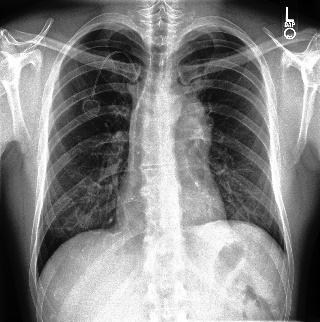

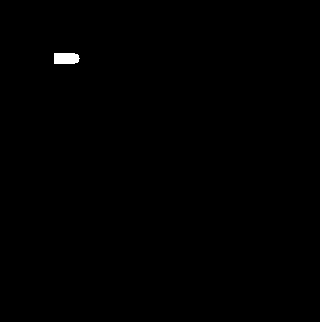

In [15]:
# Add a circle and a rectangle 'bullet' object

img = img_raw.copy()
img.show()

img = np.array(img)


img_overlay = np.zeros_like(img)

# Setting constant shape variables
circle_radius = 5
rectangle_length = 20
rectangle_width = 10


# Setting random centre of rectangle
x1 = int((width* (0.5+ np.random.uniform(low = -1, high = 1)*0.3)))
y1 = int((height*(0.4+ np.random.uniform(low = -1, high = 1)*0.3)))

rect_x_centre = x1
rect_y_centre = y1

# Drawing with angle of rotation 0 to begin with, for simplicity, and then rotation later by affine matrix
theta = 0

rect = ((rect_x_centre, rect_y_centre), (rectangle_length, rectangle_width), 0)
box = cv.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
box = np.int0(box)
cv.drawContours(img_overlay,[box],0,(255),-1)

# bullet circular 'front' placed at appropriate length along rectangular body
circle_x1 = int(x1 + rectangle_length//2)
circle_y1 = int(y1)

circle_centre1 = (circle_x1,circle_y1)

img_overlay = cv.circle(img_overlay, circle_centre1, circle_radius, 255, -1)

img_overlay_show = Image.fromarray(img_overlay)
img_overlay_show.show()

Theta is: 282.0225737194388 degrees
Rotation matrix is: 
[[  0.20829705  -0.97806561 107.39679416]
 [  0.97806561   0.20829705 -16.67742803]]


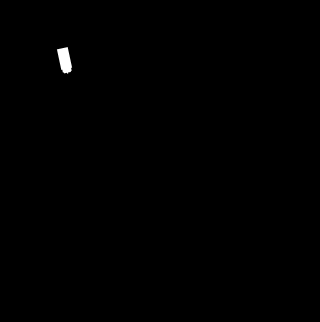

In [16]:
# Rotation of bullet randomly selected.
theta = np.random.uniform(low = 0, high = 2*np.pi)

print(f'Theta is: {theta*180/np.pi} degrees')

(h, w) = img_overlay.shape[:2]

# Rotation matrix! Thanks Stephen Elston!
M = cv.getRotationMatrix2D((rect_x_centre, rect_y_centre), theta*180/np.pi, 1.0)

print(f"Rotation matrix is: \n{M}")
rotated = cv.warpAffine(img_overlay, M, (w, h))

# Resultant bullet is rotated around its (object) centre, not the centre of the whole image.
rotated_show = Image.fromarray(rotated)
rotated_show.show()

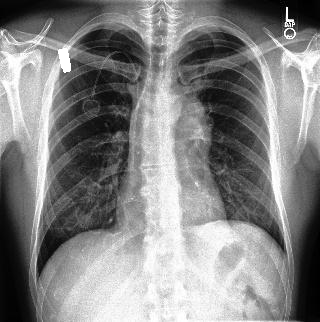

In [17]:
# Bullet aded into original image.

img[np.where(rotated == 255)] = 255

img = Image.fromarray(img)
img.show()

In [18]:
save_path = Path(f'image_result/') / sample_path_mod.with_suffix('') / Path(f'mod_bullet_x_{rect_x_centre}_y_{rect_y_centre}_rotation_{theta*180/np.pi:.0f}.jpg')

save_path.parent.mkdir(parents=True, exist_ok=True)
img.save(save_path)

You can compare my synthetic chest xray to a real one which I've included below.


Case courtesy of Dr Hidayatullah Hamidi, Radiopaedia.org, rID: 59478

![real bullet in chest](../../images/bullet_chest.JPEG)